<a href="https://colab.research.google.com/github/olsem1/WP-3/blob/master/per_mon_semit_(13).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
def calculate_train_do(data_do: str, srok_pr: int) -> str:
    """Вычисляет train_do, отнимая srok_pr месяцев от data_do."""
    # Преобразуем строку в дату (например, "2024.03" -> 1 марта 2024)
    date = datetime.strptime(data_do, "%Y.%m")
    # Вычитаем srok_pr месяцев
    train_date = date - relativedelta(months=srok_pr-1)
    # Возвращаем в формате "YYYY.MM"
    return train_date.strftime("%Y.%m")

# Переменные

In [ ]:
#до какой даты включительно используем данные для теста и трэйна
data_do = "2024.12"
#до какой даты включительно используем данные для трэйна
#train_do = "2024.03"

#на какой срок прогноз
srok_pr = 1

train_do = calculate_train_do(data_do, srok_pr)
print(f"data_do={data_do}, srok_pr={srok_pr} -> train_do={train_do}")

#тут включаем или отключаем удаление фичей на оснорве корреляции Спирмена (0 - выкл, 1 - вкл.)
switch_corr = 0

data_do=2024.12, srok_pr=1 -> train_do=2024.12


In [ ]:
pip install openpyxl fastparquet xlrd pandas shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.7 MB/s eta 0:00:00


In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns

In [ ]:
factors_all_mom = pd.read_excel('factors_all_mom_sa_ibved.xlsx')
factors_all_mom.sort_index(inplace= True)
factors_all_mom.shape

(263, 12)

# Прогнозирование

In [ ]:
pip install requests

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

In [ ]:

# Вычисление скользящего геометрического среднего по ИПЦ
# srok_pr = 6
match srok_pr:
    case 3:
        factors_all_mom['ipc_rf'] = np.exp(factors_all_mom['ipc_rf'].apply(np.log).rolling(window=3).mean())
    case 6:
        factors_all_mom['ipc_rf'] = np.exp(factors_all_mom['ipc_rf'].apply(np.log).rolling(window=6).mean())
    case 9:
        factors_all_mom['ipc_rf'] = np.exp(factors_all_mom['ipc_rf'].apply(np.log).rolling(window=9).mean())
    case 12:
        factors_all_mom['ipc_rf'] = np.exp(factors_all_mom['ipc_rf'].apply(np.log).rolling(window=12).mean())
factors_all_mom = factors_all_mom.dropna(subset=['ipc_rf'])
factors_all_mom['ipc_rf'].head(3)


,ipc_rf
0,1
1,2
2,1


In [ ]:
factors_all_mom.head()

,date,ipc_rf,ibk,ibk_fact,ibk_ozh,varll_v,varll_v_3,spros,spros_3,price_exp_3,price,izder
0,2003-02-01,1,11.298748,1.452360,21.626399,2.091702,22.930166,0.815041,20.330256,28.919689,22.128903,41.559604
1,2003-03-01,2,11.190444,1.382234,21.476358,2.256076,22.821022,0.512168,20.139808,27.833582,20.078885,40.617698
2,2003-04-01,1,11.887606,3.037819,21.123128,4.145401,22.444576,1.936245,19.809529,26.200279,19.523793,38.323106
3,2003-05-01,1,12.158487,2.623944,22.141682,2.934648,23.545605,2.313715,20.746576,27.280881,19.946583,37.184336
4,2003-06-01,1,13.017953,3.550125,22.926163,4.501011,24.639494,2.603660,21.225900,26.178978,20.695586,38.189440


# Проверка рядов на стационарность (turn on dataset)

In [ ]:
from statsmodels.tsa.stattools import adfuller
df = factors_all_mom.drop('date', axis=1)
#df = trend_factors.drop('date', axis=1)
#df = resid_factors.drop('date', axis=1)
df = df.diff()
df = df.iloc[1:]
st = 0
notst = 0
p_value = 0.05
for num, feature in enumerate(df.keys()):
  result = adfuller(df[feature])
  result_text = []
  result_text.append('ADF: {:.5}, '.format(result[0]))
  result_text.append('p-val: {:.2}, '.format(result[1]))
  if result[1] < float(p_value):
#      print('Признак:', feature, 'p-val: {:.2}, '.format(result[1]))
      st += 1
  else:
      print('Нестационарный ряд по признаку:', feature, 'p-val: {:.2}, '.format(result[1]))
      notst += 1
print('Нестационарных рядов всего:', notst, ' на уровне значимости , ', p_value)

Нестационарных рядов всего: 0  на уровне значимости ,  0.05


# Переход к первым разностям фичей (смена срока прогноза)

In [ ]:
# берем первые разницы в трендах мом
if notst>3:
    trend_factors_diff = trend_factors.copy()
    trend_factors_diff.loc[:, (trend_factors_diff.columns != "date")] = trend_factors_diff.loc[:, (trend_factors_diff.columns != "date")].diff()
    trend_factors = trend_factors_diff.iloc[1:]

In [ ]:
mes = (pd.to_datetime(data_do).to_period('M') - pd.to_datetime(train_do).to_period('M')).n+1
result_rmse = pd.DataFrame(columns=['data_do', 'train_do', 'mes', 'method', 'rmse'])

In [ ]:
#делаем фичу с номером месяца
factors_all_mom['month'] = pd.DatetimeIndex(factors_all_mom.index).month
factors_all_mom.rename(columns={"ipc_rf": "t"}, inplace=True)

# **Here Switch all, trend or resid**

In [ ]:
#делаем фичи со средними значениями и стандартными отклонениями ипц и курса на 6, 12 месяцев t_mean_lag6	t_mean_lag12	t_std_lag6	t_std_lag12	curs_mean_lag6	curs_mean_lag12	curs_std_lag6	curs_std_lag12

df=factors_all_mom.copy()

df.reset_index(drop=False, inplace=True)
lag_features = df.columns[df.columns.str.startswith(('me', 'mp', 'per'))]

window1 = 3
#window2 = 6
#window3 = 12

df_rolled_3m = df[lag_features].rolling(window=window1, min_periods=0)
#df_rolled_6m = df[lag_features].rolling(window=window2, min_periods=0)
#df_rolled_12m = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3m = df_rolled_3m.mean().shift(1).reset_index().astype(np.float32)
#df_mean_6m = df_rolled_6m.mean().shift(1).reset_index().astype(np.float32)
#df_mean_12m = df_rolled_12m.mean().shift(1).reset_index().astype(np.float32)

df_std_3m = df_rolled_3m.std().shift(1).reset_index().astype(np.float32)
#df_std_6m = df_rolled_6m.std().shift(1).reset_index().astype(np.float32)
#df_std_12m = df_rolled_12m.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3m[feature]
#    df[f"{feature}_mean_lag{window2}"] = df_mean_6m[feature]
#    df[f"{feature}_mean_lag{window3}"] = df_mean_12m[feature]

    df[f"{feature}_std_lag{window1}"] = df_std_3m[feature]
#    df[f"{feature}_std_lag{window2}"] = df_std_6m[feature]
#    df[f"{feature}_std_lag{window3}"] = df_std_12m[feature]

# df.fillna(df.mean(), inplace=True)
df.dropna(axis=0, inplace=True)

df.set_index("date", drop=True, inplace=True)
df = df.drop(['index'], axis=1)

# Удаление фичей на основе корреляции Спирмена

In [ ]:
from collections import defaultdict
# Шаг 1: Построение матрицы корреляции Спирмена
corr_matrix = df.corr(method='spearman')

# Шаг 2: Нахождение пар переменных с коэффициентом корреляции больше 0.9
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            high_corr_pairs.append(pair)

# Шаг 3: Сохранение пар в DataFrame high_corr_df
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Variable1', 'Variable2', 'Correlation'])

# Шаг 4: Подсчет количества вхождений каждой переменной в high_corr_df
var_count = defaultdict(int)
for pair in high_corr_pairs:
    var_count[pair[0]] += 1
    var_count[pair[1]] += 1

# Шаг 5: Выбор переменных для удаления (переменные, которые встречаются более одного раза)
to_remove = set()
for var, count in var_count.items():
    if count > 1:
        to_remove.add(var)

# Шаг 6: Удаление выбранных переменных из исходного DataFrame
# to_remove.add('t')
df_cor = df.drop(columns=to_remove)

# Вывод результатов
print("\nСписок переменных для удаления:")
to_remove


Список переменных для удаления:


{'ibk',
 'ibk_fact',
 'ibk_ozh',
 'price_exp_3',
 'spros',
 'spros_3',
 'varll_v',
 'varll_v_3'}

# ТУт включаем или отключаем удаление фичей на оснорве корреляции Спирмена

In [ ]:
#разбиваем датасет на тест и трэйн
if switch_corr == 1:
  data = df_cor.copy()
else:
  data = df.copy()

#data_not = data.drop('t', axis=1)
train = data[data.index < train_do]
test = data[data.index >= train_do]

X_train = train.drop(['t'], axis=1).values
y_train = train[['t']].values.ravel()
X_test = test.drop(['t'], axis=1).values
y_test = test[['t']].values.ravel()

X = data.drop(['t'], axis=1).values
y = data[['t']].values.ravel()

X_shap = data.drop(['t'], axis=1)
y_shap = data[['t']]

X_train_shap = train.drop(['t'], axis=1)
y_train_shap = train[['t']]

In [ ]:
train.columns

Index(['t', 'ibk', 'ibk_fact', 'ibk_ozh', 'varll_v', 'varll_v_3', 'spros',
       'spros_3', 'price_exp_3', 'price', 'izder', 'month'],
      dtype='object')

SCALER

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_m = pd.DataFrame(scaler.fit_transform(data), columns = data.columns, index=data.index)

X_shap_m = data_m.drop(['t'], axis=1)
y_shap_m = data_m[['t']]

X_train_m = scaler.fit_transform(X_train)
X_test_m = scaler.transform(X_test)

X_train_shap_m = scaler.fit_transform(X_train)
X_test_shap_m = scaler.transform(X_test)

result = pd.DataFrame()
result['y_test']=pd.DataFrame(np.array(y_test), index = test.index, columns=['y_test'])

In [ ]:
X_test

array([[ 3.77117666, -2.446414  , 10.18445312, -2.72769745, 10.32893642,
        -2.16472948, 10.04006908, 28.34888471, 20.37599425, 41.24099646,
         1.        ]])

CV

In [ ]:
#подготовка к разбивке трэйна на валидационные выборки
#tscv = TimeSeriesSplit(gap=0, max_train_size=137, n_splits=12, test_size=12)
tscv = TimeSeriesSplit(n_splits=12, test_size=srok_pr)
print(tscv)

#Тут можно посмотреть фолды
for i, (train_index, test_index) in enumerate(tscv.split(X_train_m)):
  print(f"Fold {i}:")
  print(f"  Train: index={train_index}")
  print(f"  Test:  index={test_index}")

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=12, test_size=1)
Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 22

<ipython-input-22-2203660119>:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = spearmanr(X_shap_m[feature], y_shap_m['t'])


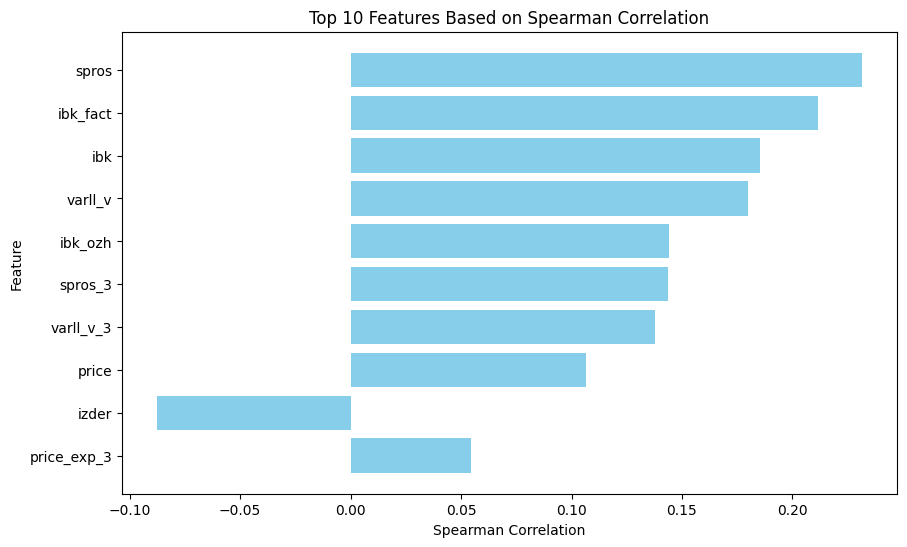

In [ ]:
# Вычисление корреляции Спирмена фичей с целевой переменной
from scipy.stats import spearmanr
correlations = {}
for feature in X_shap_m.columns:
    correlation, _ = spearmanr(X_shap_m[feature], y_shap_m['t'])
    correlations[feature] = correlation

# Преобразование словаря в DataFrame для сортировки
correlations_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Spearman_Correlation'])

# Сортировка по абсолютному значению корреляции
correlations_df['Abs_Spearman_Correlation'] = correlations_df['Spearman_Correlation'].abs()
correlations_df = correlations_df.sort_values(by='Abs_Spearman_Correlation', ascending=False)


# Выбор топ-10 фичей
top_10_features = correlations_df.head(20)

# Построение графика
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Spearman_Correlation'], color='skyblue')
plt.xlabel('Spearman Correlation')
plt.ylabel('Feature')
plt.title('Top 10 Features Based on Spearman Correlation')
plt.gca().invert_yaxis()  # Чтобы наиболее важные фичи были сверху
plt.show()

correlations_df.set_index('Feature', inplace=True)
coefs = pd.DataFrame({'coef_corr': correlations_df['Abs_Spearman_Correlation']})
#coefs = pd.DataFrame(top_10_features['Abs_Spearman_Correlation'], columns=["Coef_corr"], index=correlations_df.head(10).columns)

# Lasso

rmse: 0.44948


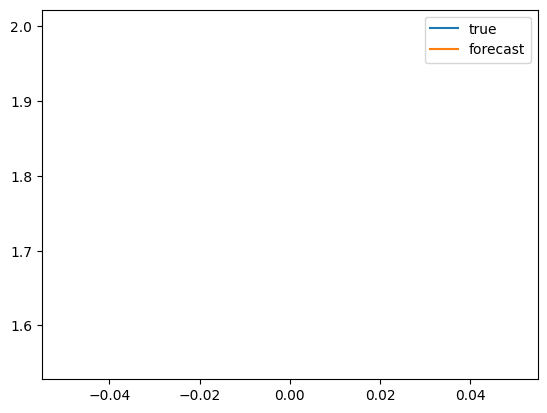

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
alpha_values = {'alpha': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,0.07, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100]}


lasso_model = make_pipeline(StandardScaler(), Lasso(alpha=0.1))
#lasso_model.fit(X_train, y_train)
#lasso_model = make_pipeline(StandardScaler(), GridSearchCV(Lasso(), alpha_values, scoring='neg_mean_squared_error', cv=tscv))
lasso_model.fit(X_train, y_train)

forecast = lasso_model.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

In [ ]:
result['Lasso']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Lasso'])
result_Lasso = {'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'Lasso',
                'rmse': mean_squared_error(y_test, forecast) ** 0.5}
#result_rmse = result_rmse.append(result_Lasso, ignore_index = True)
result_rmse = pd.concat([result_rmse, pd.DataFrame([result_Lasso])], ignore_index=True)
result_rmse

<ipython-input-24-3945463175>:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_rmse = pd.concat([result_rmse, pd.DataFrame([result_Lasso])], ignore_index=True)


,data_do,train_do,mes,method,rmse
0,2024.12,2024.12,1,Lasso,0.449476


Text(0.5, 1.0, 'Lasso model')

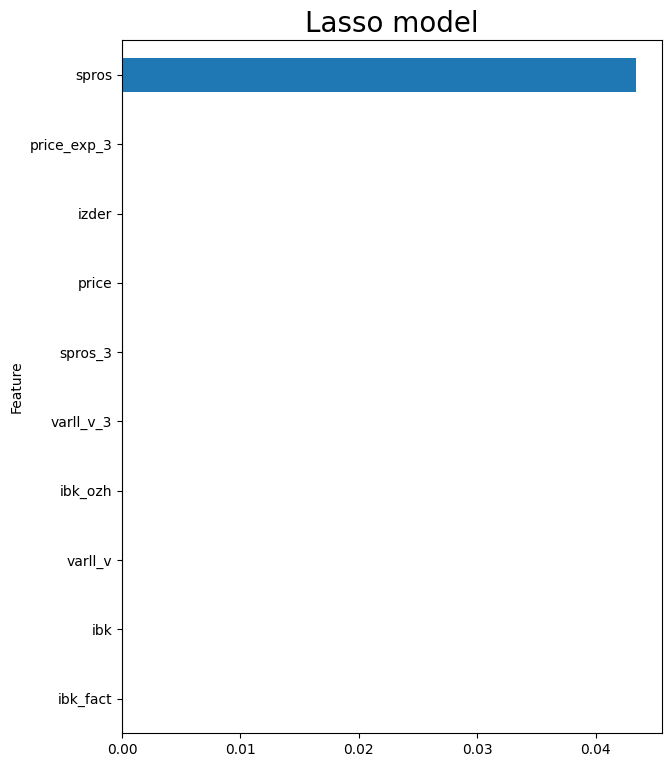

In [ ]:
import matplotlib.pyplot as plt

coefs['Coef_Lasso']=pd.DataFrame(np.array(lasso_model[1].coef_), index=X_train_shap.columns)

coefs_top10_ind_lasso = coefs['Coef_Lasso'].abs().nlargest(10).index
coefs_top10_lasso = coefs['Coef_Lasso'][coefs_top10_ind_lasso].sort_values(ascending=True)

#coefs_top10 = coefs['Coefficients'].abs().nlargest(10).sort_values(ascending=False)
coefs_top10_lasso.plot(kind="barh", figsize=(9, 9))

plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
#plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title("Lasso model", fontsize=20)


In [ ]:
# создадим новый датафрейм с выбранными столбцами
X_shap_lasso_coefs_top10 = X_shap.loc[:, [col for col in X_shap.columns if col in coefs_top10_lasso]]

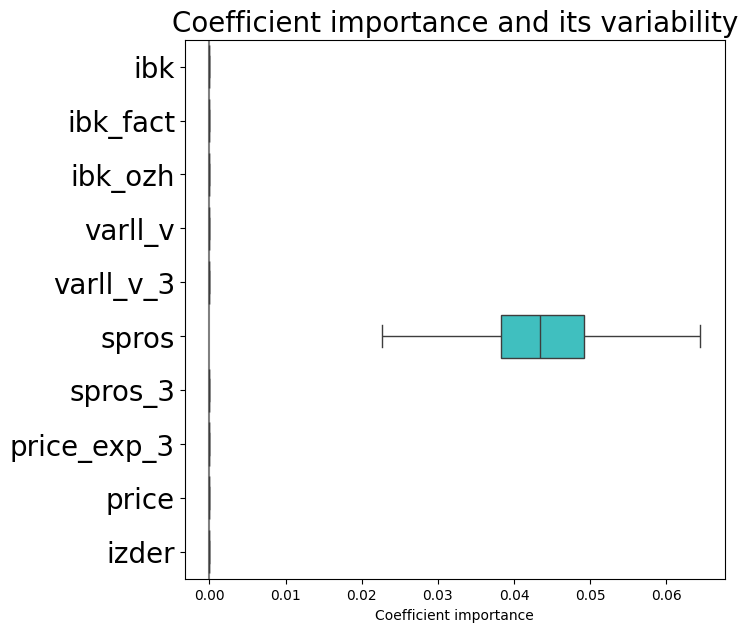

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    lasso_model,
#    X_shap,
#    y_shap,
    X_train_shap,
    y_train_shap,
#    error_score='raise',
    cv=RepeatedKFold(n_splits=14, n_repeats=14),
#    cv=tscv,
    return_estimator=True,
    n_jobs=2,
)
coefs_var_lasso = pd.DataFrame(
#    [model[1].coef_ for model in cv_model["estimator"]],
    [lasso_model[1].coef_ for lasso_model in cv_model['estimator']],
    columns=X_train_shap.columns,
)
coefs_10_lasso = coefs_var_lasso.loc[:, [col for col in coefs_var_lasso.columns if col in coefs_top10_lasso]]
plt.figure(figsize=(9, 7))
sns.boxplot(data=coefs_10_lasso, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability", fontsize=20)
plt.subplots_adjust(left=0.3)
plt.rc('ytick', labelsize=20)


# Ridge (l2-regularisation)

rmse: 0.40678
normed rmse: 20.34%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde

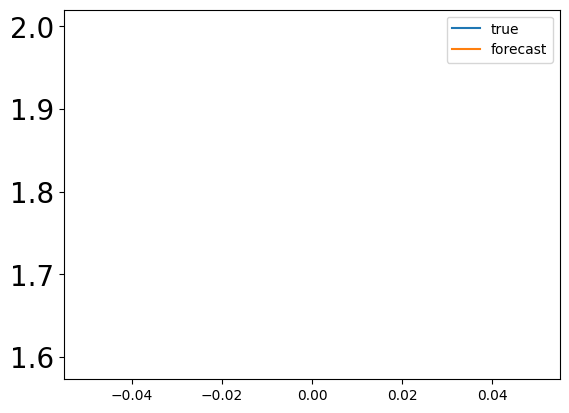

In [ ]:
from sklearn.linear_model import RidgeCV
#param_grid = {'alpha': np.linspace(0.001, 100, 300)}
#GSRidge = GridSearchCV(Ridge(), param_grid, cv=tscv)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#ridgeCV_model = make_pipeline(StandardScaler(), RidgeCV(cv=tscv))
#ridgeCV_model.fit(X_train, y_train)
ridge_model = make_pipeline(StandardScaler(), Ridge(alpha=5))
ridge_model.fit(X_train, y_train)

GSRidge = RidgeCV(cv=tscv).fit(X_train_m, y_train)

forecast = ridge_model.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

#print (GSRidge.best_params_['alpha'])
plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

In [ ]:
result['Ridge']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Ridge'])
result_Ridge = {'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'Ridge',
                'rmse': mean_squared_error(y_test, forecast) ** 0.5}
result_rmse = pd.concat([result_rmse, pd.DataFrame([result_Ridge])], ignore_index=True)
#result_rmse = result_rmse.append(result_Ridge, ignore_index = True)
result_rmse

,data_do,train_do,mes,method,rmse
0,2024.12,2024.12,1,Lasso,0.449476
1,2024.12,2024.12,1,Ridge,0.406776


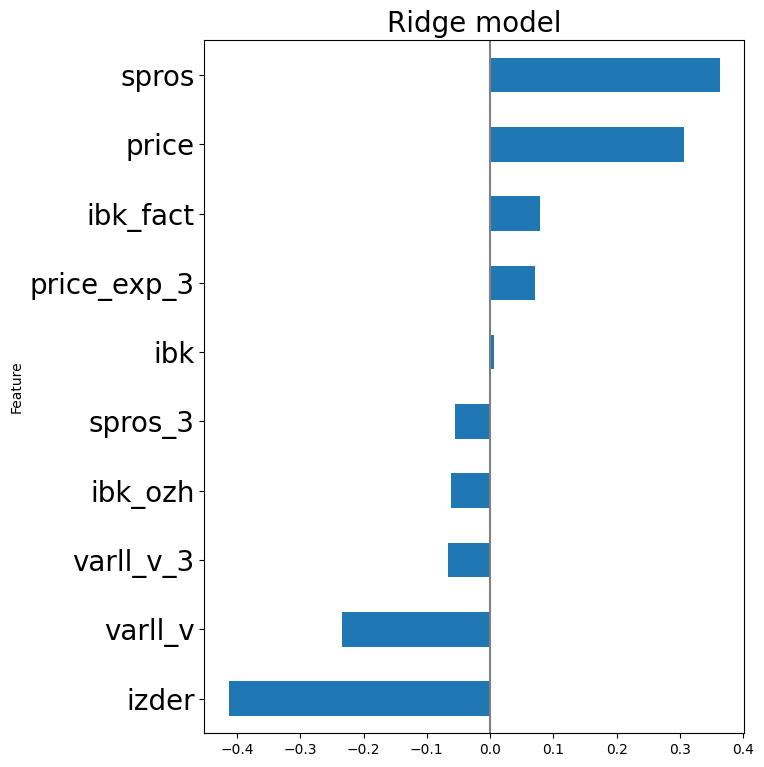

In [ ]:
coefs['Coef_Ridge']=pd.DataFrame(np.array(ridge_model[1].coef_), index=X_train_shap.columns)
coefs_top10_ind_ridge = coefs['Coef_Ridge'].abs().nlargest(10).index
coefs_top10_ridge = coefs['Coef_Ridge'][coefs_top10_ind_ridge].sort_values(ascending=True)

#coefs_top10 = coefs['Coefficients'].abs().nlargest(10).sort_values(ascending=False)
coefs_top10_ridge.plot(kind="barh", figsize=(9, 9))
plt.title("Ridge model", fontsize = 20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.rc('ytick', labelsize=20)

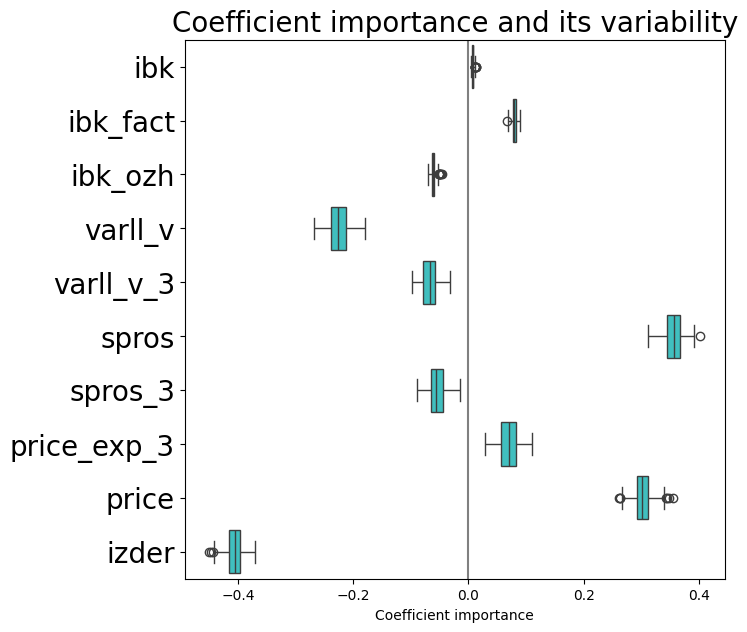

In [ ]:
cv_model = cross_validate(
    ridge_model,
    X_train,
    y_train,
#    cv=tscv,
    cv=RepeatedKFold(n_splits=14, n_repeats=14),
    return_estimator=True,
    n_jobs=2,
)
coefs_var_ridge = pd.DataFrame(
    [ridge_model[1].coef_ for ridge_model in cv_model["estimator"]],
    columns=X_train_shap.columns,
)
coefs_10_ridge = coefs_var_ridge.loc[:, [col for col in coefs_var_ridge.columns if col in coefs_top10_ridge]]

plt.figure(figsize=(9, 7))
sns.boxplot(data=coefs_10_ridge, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability", fontsize=20)
plt.subplots_adjust(left=0.3)
plt.rc('ytick', labelsize=20)

# ElasticNet (l1+l2-regularisation)

rmse: 0.47018


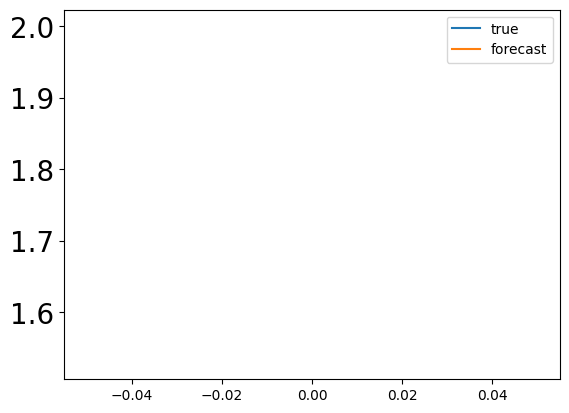

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
param_grid = {'alpha': np.linspace(0, 2, 100)}

EN_model = make_pipeline(StandardScaler(), ElasticNet(alpha=0.1))
EN_model.fit(X_train, y_train)

forecast = EN_model.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

In [ ]:
result['ElasticNet']=pd.DataFrame(np.array(forecast), index = test.index, columns=['ElasticNet'])
result_ElasticNet = {'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'ElasticNet',
                'rmse': mean_squared_error(y_test, forecast) ** 0.5}
#result_rmse = result_rmse.append(result_ElasticNet, ignore_index = True)
result_rmse = pd.concat([result_rmse, pd.DataFrame([result_ElasticNet])], ignore_index=True)
result_rmse

,data_do,train_do,mes,method,rmse
0,2024.12,2024.12,1,Lasso,0.449476
1,2024.12,2024.12,1,Ridge,0.406776
2,2024.12,2024.12,1,ElasticNet,0.470176


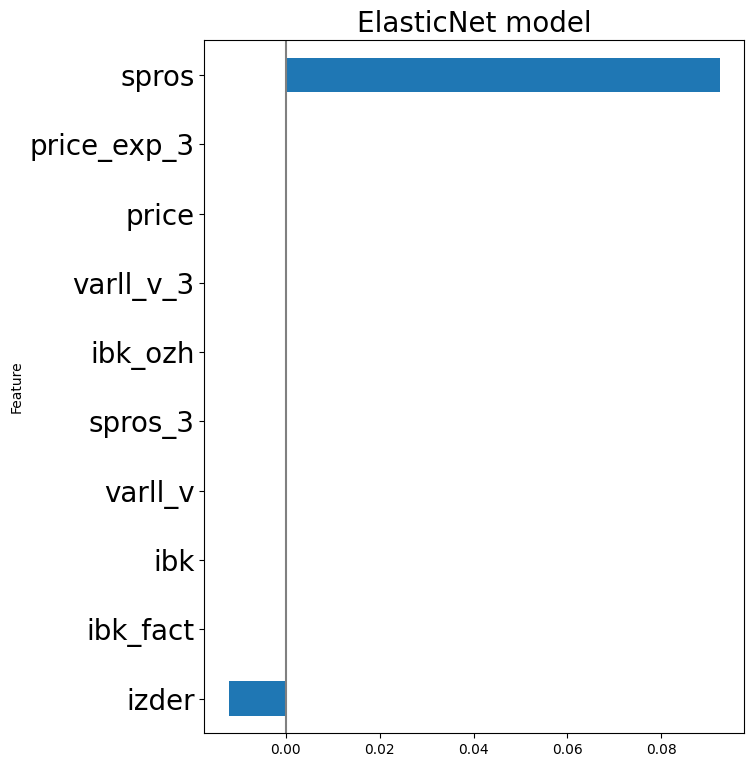

In [ ]:
coefs['Coef_EN']=pd.DataFrame(np.array(EN_model[1].coef_), index=X_train_shap.columns)

coefs_top10_ind_EN = coefs['Coef_EN'].abs().nlargest(10).index
coefs_top10_EN = coefs['Coef_EN'][coefs_top10_ind_EN].sort_values(ascending=True)

#coefs_top10 = coefs['Coefficients'].abs().nlargest(10).sort_values(ascending=False)
coefs_top10_EN.plot(kind="barh", figsize=(9, 9))
plt.title("ElasticNet model", fontsize=20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

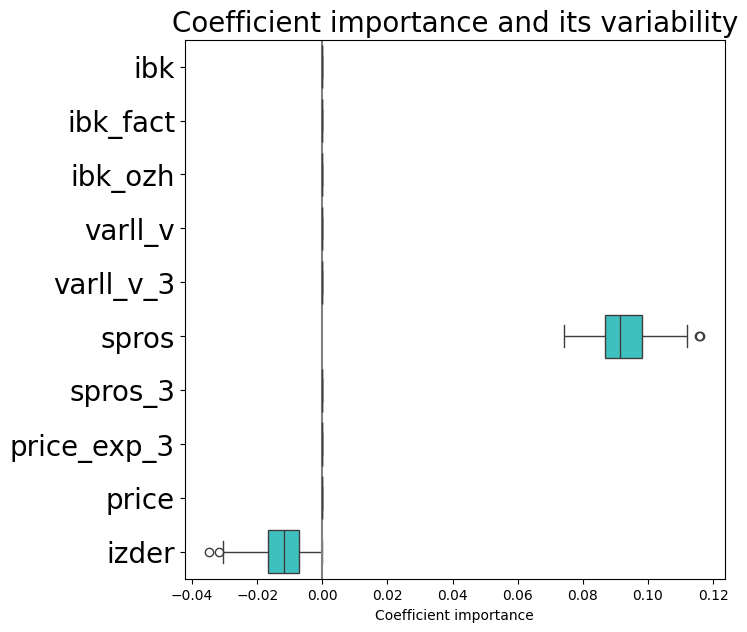

In [ ]:
cv_model = cross_validate(
    EN_model,
    X_train,
    y_train,
#    cv=tscv,
    cv = RepeatedKFold(n_splits=14, n_repeats=14),
    return_estimator=True,
    n_jobs=2,
)
coefs_var_EN = pd.DataFrame(
    [EN_model[1].coef_ for EN_model in cv_model["estimator"]],
    columns=X_train_shap.columns,
)
coefs_10_EN = coefs_var_EN.loc[:, [col for col in coefs_var_EN.columns if col in coefs_top10_EN]]

plt.figure(figsize=(9, 7))
sns.boxplot(data=coefs_10_EN, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability", fontsize=20)
plt.subplots_adjust(left=0.3)
plt.rc('ytick', labelsize=20)

# LightGBM

In [ ]:
pip install shap --no-input

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

,data_do,train_do,mes,method,rmse
0,2024.12,2024.12,1,Lasso,0.449476
1,2024.12,2024.12,1,Ridge,0.406776
2,2024.12,2024.12,1,ElasticNet,0.470176
3,2024.12,2024.12,1,GSLGBM,0.075035


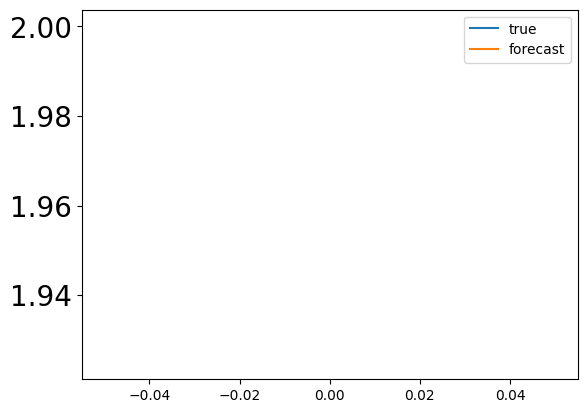

In [ ]:
from lightgbm import LGBMRegressor
param_grid = {"max_depth": [1, 3],
              "n_estimators": [300],
              "learning_rate": [0.01, 0.2, 1],
              "alpha": [0.2, 0.1],
#              "eval_metric": "rmse",
#              "early_stopping_rounds": = 20,
              }

GSLGBM = GridSearchCV(LGBMRegressor(), param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
GSLGBM.fit(X_train, y_train)

print("The best hyperparameters are ", GSLGBM.best_params_)
# make predictions
GSLGBM_forecast = GSLGBM.predict(X_test)
plt.plot(y_test, label='true')
plt.plot(GSLGBM_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSLGBM_forecast) ** 0.5))

result['GSLGBM']=pd.DataFrame(np.array(GSLGBM_forecast), index = test.index, columns=['GSLGBM'])
result_GSLGBM = {'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSLGBM',
                'rmse': mean_squared_error(y_test, GSLGBM_forecast) ** 0.5}

result_rmse = pd.concat([result_rmse, pd.DataFrame([result_GSLGBM])], ignore_index=True)
result_rmse

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 10
[LightGBM] [Info] Start training from score 1.549618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

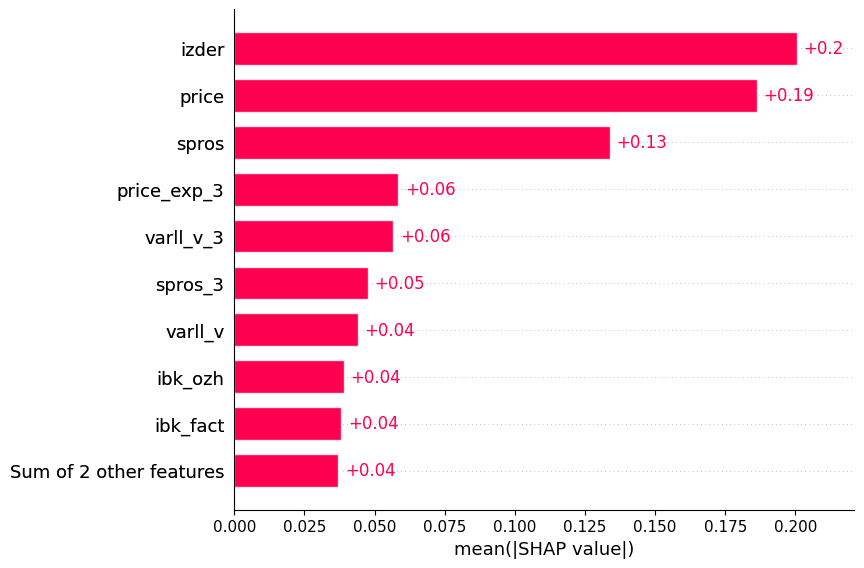

In [ ]:
import matplotlib.pylab as pl
from sklearn.model_selection import train_test_split
import shap
import xgboost
import lightgbm
shap.initjs()
# train an lightgbm model

model = lightgbm.LGBMRegressor().fit(X_train_shap, y_train_shap)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_shap)
shap_values = explainer(X_train_shap)

# visualize the first prediction's explanation
shap.plots.bar(shap_values)

#coefs['Coef_GB']=pd.DataFrame(np.array(GB.feature_importances_), index=X_train_shap.columns)

#df_shap = pd.DataFrame(np.array(shap_values[0]), index=X_train_shap.columns)
#df_shap.head

# Gradient Boosting regression

rmse: 0.1477


,data_do,train_do,mes,method,rmse
0,2024.12,2024.12,1,Lasso,0.449476
1,2024.12,2024.12,1,Ridge,0.406776
2,2024.12,2024.12,1,ElasticNet,0.470176
3,2024.12,2024.12,1,GSLGBM,0.075035
4,2024.12,2024.12,1,GB,0.147723


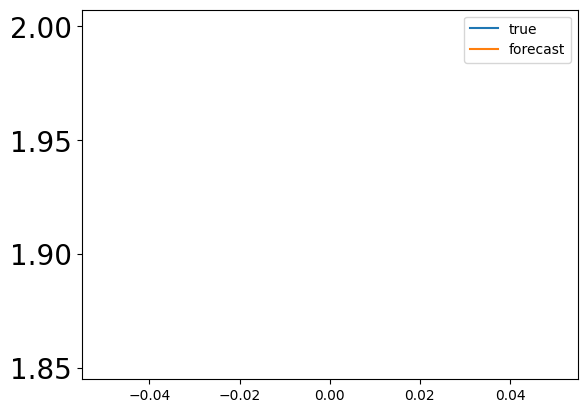

In [ ]:
from sklearn import datasets, ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.1,
    "loss": "squared_error"}

GB = ensemble.GradientBoostingRegressor(**params)
GB.fit(X_train_m, y_train)
# make predictions
GB_forecast = GB.predict(X_test_m)
plt.plot(y_test, label='true')
plt.plot(GB_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GB_forecast) ** 0.5))

result['GB']=pd.DataFrame(np.array(GB_forecast), index = test.index, columns=['GB'])

result_GB = {'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GB',
                'rmse': mean_squared_error(y_test, GB_forecast) ** 0.5}
result_rmse = pd.concat([result_rmse, pd.DataFrame([result_GB])], ignore_index=True)
result_rmse

# GSXGB

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde

Best parameters: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
rmse: 0.2154


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


,data_do,train_do,mes,method,rmse
0,2024.12,2024.12,1,Lasso,0.449476
1,2024.12,2024.12,1,Ridge,0.406776
2,2024.12,2024.12,1,ElasticNet,0.470176
3,2024.12,2024.12,1,GSLGBM,0.075035
4,2024.12,2024.12,1,GB,0.147723
5,2024.12,2024.12,1,GSXGB1,0.215444


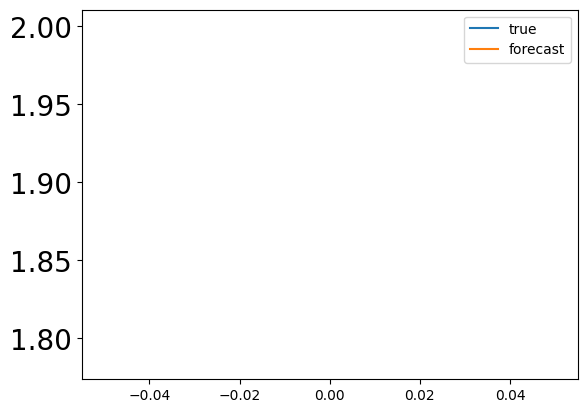

In [ ]:
param_grid = {'max_depth': [1, 3, 5],
              'n_estimators': [100, 300],
              "learning_rate": [0.1, 0.5]}

GSXGB = GridSearchCV(XGBRegressor(objective ='reg:squarederror'), param_grid, cv=tscv)
#GSXGB.fit(X_train_m, y_train, verbose=False)
GSXGB.fit(X_train, y_train, verbose=False)

print("Best parameters: {}".format(GSXGB.best_params_))
#print("Best estimator:\n{}".format(GSXGB.best_estimator_))

# make predictions
#GSXGB_forecast = GSXGB.predict(X_test_m)
GSXGB_forecast = GSXGB.predict(X_test)
plt.plot(y_test, label='true')
plt.plot(GSXGB_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSXGB_forecast) ** 0.5))

result['GSXGB']=pd.DataFrame(np.array(GSXGB_forecast), index = test.index, columns=['GSXGB'])

result_GSXGB = {'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSXGB1',
                'rmse': mean_squared_error(y_test, GSXGB_forecast) ** 0.5}
result_rmse = pd.concat([result_rmse, pd.DataFrame([result_GSXGB])], ignore_index=True)
#result_rmse = result_rmse.append(result_GSXGB, ignore_index = True)
result_rmse

rmse: 0.0216


,data_do,train_do,mes,method,rmse
0,2024.12,2024.12,1,Lasso,0.449476
1,2024.12,2024.12,1,Ridge,0.406776
2,2024.12,2024.12,1,ElasticNet,0.470176
3,2024.12,2024.12,1,GSLGBM,0.075035
4,2024.12,2024.12,1,GB,0.147723
5,2024.12,2024.12,1,GSXGB1,0.215444
6,2024.12,2024.12,1,GSXGB2,0.021559


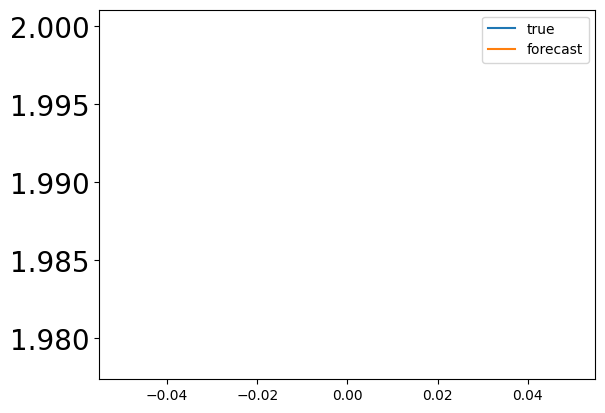

In [ ]:
#param_grid = {'max_depth': [1, 3,],
#              'n_estimators': [50, 300]}

GSXGB = xgboost.XGBRegressor(random_state=42, objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)
#GSXGB.fit(X_train_m, y_train)
GSXGB.fit(X_train, y_train)

# make predictions
#GSXGB_forecast = GSXGB.predict(X_test_m)
GSXGB_forecast = GSXGB.predict(X_test)
plt.plot(y_test, label='true')
plt.plot(GSXGB_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSXGB_forecast) ** 0.5))

result['GSXGB']=pd.DataFrame(np.array(GSXGB_forecast), index = test.index, columns=['GSXGB'])

result_GSXGB = {'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSXGB2',
                'rmse': mean_squared_error(y_test, GSXGB_forecast) ** 0.5}
result_rmse = pd.concat([result_rmse, pd.DataFrame([result_GSXGB])], ignore_index=True)
#result_rmse = result_rmse.append(result_GSXGB, ignore_index = True)
result_rmse

In [ ]:
!pip uninstall -y scikit-learn
#pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2


In [ ]:
import sklearn

print(sklearn.__version__)

1.5.2


Shap

In [ ]:
pip install shap --no-input

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 98.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


# Расчет shap-value

In [ ]:
"""
#вариант 1
import os
import shap
import xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

data_shape = data
data_shape_x = data_shape.drop('t', axis=1)
random.seed(42)
os.makedirs('output_dir', exist_ok=True)

# Разделяем данные на обучающую и тестовую выборки
X_train_1 = data_shape[:-12]  # Берем все, кроме последних 12 строк для обучения
X_test_1 = data_shape[-12:]   # Последние 12 строк для тестирования

# 2. Обучение модели XGBoost для каждого горизонта прогнозирования
target = 't'

# Разделяем данные на признаки (features) и целевую переменную
y_train_1 = X_train_1[target]
X_train_features = X_train_1.drop('t', axis=1)
y_test_1 = X_test_1[target]
X_test_features = X_test_1.drop('t', axis=1)

# Создаем и обучаем модель XGBoost
model = xgboost.XGBRegressor(random_state=42, objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=3)
model.fit(X_train_features, y_train_1)

# 3. Вычисление SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_features)

# 4. Определение наиболее значимых предикторов (топ-N)
shap_importance = pd.DataFrame(index=X_test_features.columns, data=np.abs(shap_values).mean(axis=0), columns=['mean(|SHAP|)'])
shap_importance['sign'] = np.sign(shap_values.mean(axis=0))  # Определяем знак влияния
top_n = 10  # Количество наиболее значимых предикторов
top_features = shap_importance.sort_values(by='mean(|SHAP|)', ascending=False).head(top_n).index

# 5. Фильтрация SHAP values и данных для топ-N предикторов
shap_values_top = shap_values[:, X_test_features.columns.isin(top_features)]
X_test_features_top = X_test_features[top_features]

# 6. Визуализация SHAP values для топ-N предикторов и сохранение в файл .jpg
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_top, X_test_features_top, plot_type="dot", show=False)
plt.title(f'Top {top_n} SHAP Values for {srok_pr}-Month Inflation Forecast (Color indicates direction of impact)')
plt.savefig(os.path.join('output_dir', f'shap_summary_{srok_pr}_months.jpg'), format='jpg', bbox_inches='tight')
plt.show()
plt.close()  # Закрываем график, чтобы освободить память

# 7. Визуализация значимости предикторов с учетом знака и сохранение в файл .jpg
shap_importance_top = shap_importance.loc[top_features]

plt.figure(figsize=(10, 6))
colors = np.where(shap_importance_top['sign'] == 1, 'green', 'red')  # Зеленый для положительного, красный для отрицательного влияния
plt.barh(shap_importance_top.index, shap_importance_top['mean(|SHAP|)'], color=colors)
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.title(f'Top {top_n} Feature Importance for {srok_pr}-Month Inflation Forecast (Color indicates direction of impact)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.savefig(os.path.join('output_dir', f'feature_importance_{srok_pr}_months.jpg'), format='jpg', bbox_inches='tight')
plt.close()  # Закрываем график, чтобы освободить память

# 8. Сохранение SHAP values в Excel файл
shap_values_df = pd.DataFrame(shap_values_top, columns=X_test_features_top.columns)
#shap_values_df = pd.DataFrame(np.abs(shap_values_top), columns=X_test_features_top.columns)
shap_values_df.to_excel(os.path.join('output_dir', f'shap_values_{srok_pr}_months.xlsx'), index=False)

# 9. Вывод таблицы с важностью признаков
print(f'\nTop {top_n} Mean Absolute SHAP Values for {srok_pr}-Month Forecast:\n{shap_importance_top.sort_values(by="mean(|SHAP|)", ascending=False)}')
"""

'\n#вариант 1\nimport os\nimport shap\nimport xgboost\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport random\n\ndata_shape = data\ndata_shape_x = data_shape.drop(\'t\', axis=1)\nrandom.seed(42)\nos.makedirs(\'output_dir\', exist_ok=True)\n\n# Разделяем данные на обучающую и тестовую выборки\nX_train_1 = data_shape[:-12]  # Берем все, кроме последних 12 строк для обучения\nX_test_1 = data_shape[-12:]   # Последние 12 строк для тестирования\n\n# 2. Обучение модели XGBoost для каждого горизонта прогнозирования\ntarget = \'t\'\n\n# Разделяем данные на признаки (features) и целевую переменную\ny_train_1 = X_train_1[target]\nX_train_features = X_train_1.drop(\'t\', axis=1)\ny_test_1 = X_test_1[target]\nX_test_features = X_test_1.drop(\'t\', axis=1)\n\n# Создаем и обучаем модель XGBoost\nmodel = xgboost.XGBRegressor(random_state=42, objective=\'reg:squarederror\', n_estimators=200, learning_rate=0.1, max_depth=3)\nmodel.fit(X_train_features, y_train_1)\n\n# 3

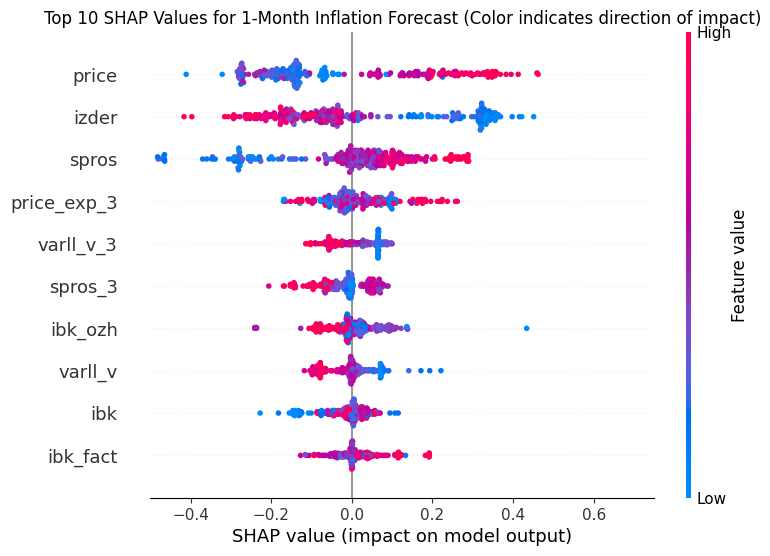


Top 10 Mean Absolute SHAP Values for 1-Month Forecast:
             mean(|SHAP|)  sign
price            0.191195  -1.0
izder            0.176512   1.0
spros            0.123691  -1.0
price_exp_3      0.059711   1.0
varll_v_3        0.048410   1.0
spros_3          0.047298  -1.0
ibk_ozh          0.044886   1.0
varll_v          0.040411  -1.0
ibk              0.038120  -1.0
ibk_fact         0.034543   1.0


In [ ]:
#вариант 2
import os
import shap
import xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
data_x = data.drop('t', axis=1)
random.seed(42)
os.makedirs('output_dir_2', exist_ok=True)

# 2. Обучение модели XGBoost для каждого горизонта прогнозирования
target = 't'

# Разделяем данные на признаки (features) и целевую переменную
data_y = data[target]

# Создаем и обучаем модель XGBoost
model = xgboost.XGBRegressor(random_state=42, objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=3)
model.fit(data_x, data_y)

# 3. Вычисление SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_x)

#shap.summary_plot(shap_values, data_x, max_display=10)

# 4. Определение наиболее значимых предикторов (топ-N)
shap_importance = pd.DataFrame(index=data_x.columns, data=np.abs(shap_values).mean(axis=0), columns=['mean(|SHAP|)'])
shap_importance['sign'] = np.sign(shap_values.mean(axis=0))  # Определяем знак влияния
top_n = 10  # Количество наиболее значимых предикторов
top_features = shap_importance.sort_values(by='mean(|SHAP|)', ascending=False).head(top_n).index

# 5. Фильтрация SHAP values и данных для топ-N предикторов
shap_values_top = shap_values[:, data_x.columns.isin(top_features)]
data_x_top = data_x[top_features]

# 6. Визуализация SHAP values для топ-N предикторов и сохранение в файл .jpg
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, data_x, plot_type="dot", max_display=10, show=False)
plt.xlim(-0.5, 0.75)
plt.title(f'Top {top_n} SHAP Values for {srok_pr}-Month Inflation Forecast (Color indicates direction of impact)')
plt.savefig(os.path.join('output_dir_2', f'shap_summary_{srok_pr}_months.jpg'), format='jpg', bbox_inches='tight')
plt.show()
plt.close()  # Закрываем график, чтобы освободить память

# 7. Визуализация значимости предикторов с учетом знака и сохранение в файл .jpg
shap_importance_top = shap_importance.loc[top_features]

plt.figure(figsize=(10, 6))
colors = np.where(shap_importance_top['sign'] == 1, 'green', 'red')  # Зеленый для положительного, красный для отрицательного влияния
plt.barh(shap_importance_top.index, shap_importance_top['mean(|SHAP|)'], color=colors)
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.title(f'Top {top_n} Feature Importance for {srok_pr}-Month Inflation Forecast (Color indicates direction of impact)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.savefig(os.path.join('output_dir_2', f'feature_importance_{srok_pr}_months.jpg'), format='jpg', bbox_inches='tight')
plt.close()  # Закрываем график, чтобы освободить память

# 8. Сохранение SHAP values в Excel файл
shap_values_df = pd.DataFrame(shap_values_top, columns=data_x_top.columns)
#shap_values_df = pd.DataFrame(np.abs(shap_values_top), columns=X_test_features_top.columns)
shap_values_df.to_excel(os.path.join('output_dir_2', f'shap_values_{srok_pr}_months.xlsx'), index=False)

#shap_values_df = pd.DataFrame(np.abs(shap_values_top), columns=X_test_features_top.columns)
shap_importance_top.to_excel(os.path.join('output_dir_2', f'shap_importance_top{srok_pr}_months.xlsx'))


# 9. Вывод таблицы с важностью признаков
print(f'\nTop {top_n} Mean Absolute SHAP Values for {srok_pr}-Month Forecast:\n{shap_importance_top.sort_values(by="mean(|SHAP|)", ascending=False)}')

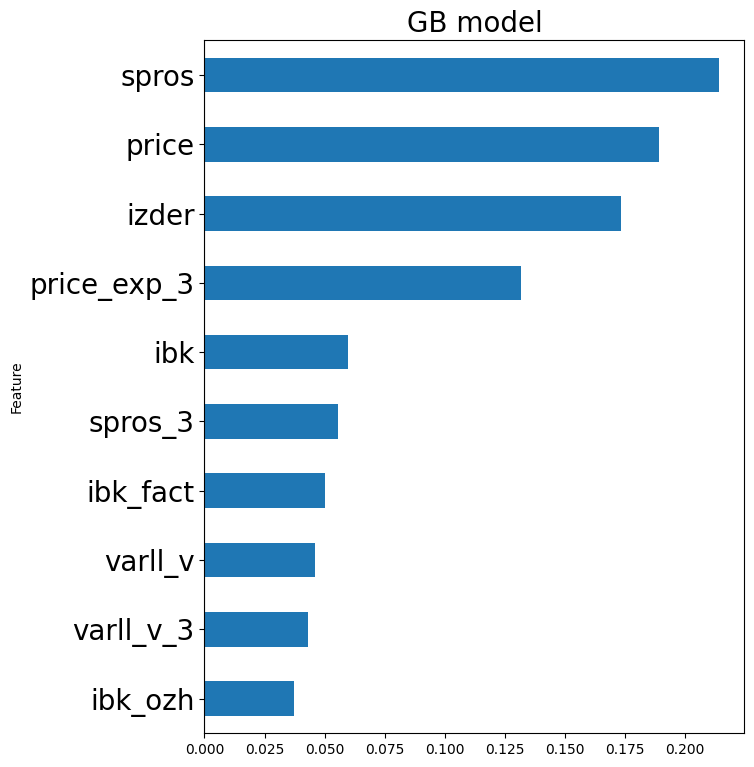

In [ ]:
coefs['Coef_GB']=pd.DataFrame(np.array(GB.feature_importances_), index=X_train_shap.columns)
#coefs = pd.DataFrame(
#    GB.feature_importances_, columns=["Coef_GB"], index=X_train_shap.columns
#)
coefs_top10_ind_GB = coefs['Coef_GB'].abs().nlargest(10).index
coefs_top10_GB = coefs['Coef_GB'][coefs_top10_ind_GB].sort_values(ascending=True)

#coefs_top10 = coefs['Coefficients'].abs().nlargest(10).sort_values(ascending=False)
coefs_top10_GB.plot(kind="barh", figsize=(9, 9))
plt.title("GB model", fontsize=20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.rc('ytick', labelsize=20)

In [ ]:
#coefs['mean'] = (coefs.iloc[:,:4]*result_rmse['rmse'][:4]).sum(axis=1)/result_rmse['rmse'].sum()
coefs['mean'] = coefs.iloc[:,:6].mean(axis=1)

In [ ]:
coefs

,coef_corr,Coef_Lasso,Coef_Ridge,Coef_EN,Coef_GB,mean
Feature,,,,,,
spros,0.231400,0.043431,0.363256,0.092510,0.213906,0.188901
ibk_fact,0.211764,0.000000,0.079387,0.000000,0.050334,0.068297
ibk,0.185382,0.000000,0.006831,0.000000,0.059782,0.050399
varll_v,0.179743,0.000000,-0.234447,0.000000,0.045852,-0.001770
ibk_ozh,0.144298,0.000000,-0.061267,-0.000000,0.037295,0.024065
spros_3,0.143895,0.000000,-0.055117,-0.000000,0.055770,0.028910
varll_v_3,0.137954,0.000000,-0.067210,-0.000000,0.043001,0.022749
price,0.106738,0.000000,0.307142,0.000000,0.189166,0.120609
izder,0.087505,-0.000000,-0.412689,-0.012148,0.173236,-0.032819


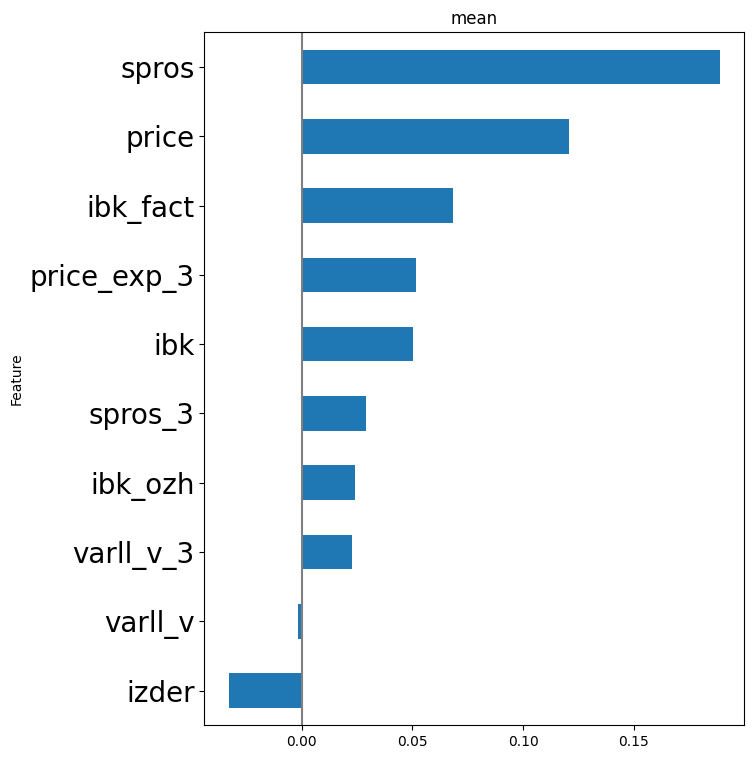

In [ ]:
#coefs['Coef_mean']=pd.DataFrame(coefs['mean'], index=X_train_shap.columns)
#coefs = pd.DataFrame(
#    GB.feature_importances_, columns=["Coef_GB"], index=X_train_shap.columns
#)
coefs_top10_ind = coefs['mean'].abs().nlargest(10).index
coefs_top10 = coefs['mean'][coefs_top10_ind].sort_values(ascending=True)

#coefs_top10 = coefs['Coefficients'].abs().nlargest(10).sort_values(ascending=False)
coefs_top10.plot(kind="barh", figsize=(9, 9))
plt.title("mean")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [ ]:
coefs.to_excel('coefs.xlsx')
result_rmse.to_excel('result_rmse.xlsx')

In [ ]:
result.to_excel('result.xlsx')

In [ ]:
# импортируем файл с ежедневными значениями
"""
import pandas as pd

# Загрузка данных из файла
df = pd.read_excel('RC.xlsx')

# Преобразование поля DT в datetime (если ещё не)
df['DT'] = pd.to_datetime(df['DT'])

# Группировка по году и месяцу, расчет среднего по ruo
monthly_avg = df.groupby([df['DT'].dt.year, df['DT'].dt.month])['ruo'].mean()

# Переименование индексов для удобства
monthly_avg.index.names = ['Year', 'Month']
monthly_avg = monthly_avg.reset_index()

# Сохранение в новый файл
monthly_avg.to_excel('monthly_averages.xlsx', index=False)
"""

"\nimport pandas as pd\n\n# Загрузка данных из файла\ndf = pd.read_excel('RC.xlsx')\n\n# Преобразование поля DT в datetime (если ещё не)\ndf['DT'] = pd.to_datetime(df['DT'])\n\n# Группировка по году и месяцу, расчет среднего по ruo\nmonthly_avg = df.groupby([df['DT'].dt.year, df['DT'].dt.month])['ruo'].mean()\n\n# Переименование индексов для удобства\nmonthly_avg.index.names = ['Year', 'Month']\nmonthly_avg = monthly_avg.reset_index()\n\n# Сохранение в новый файл\nmonthly_avg.to_excel('monthly_averages.xlsx', index=False)\n"

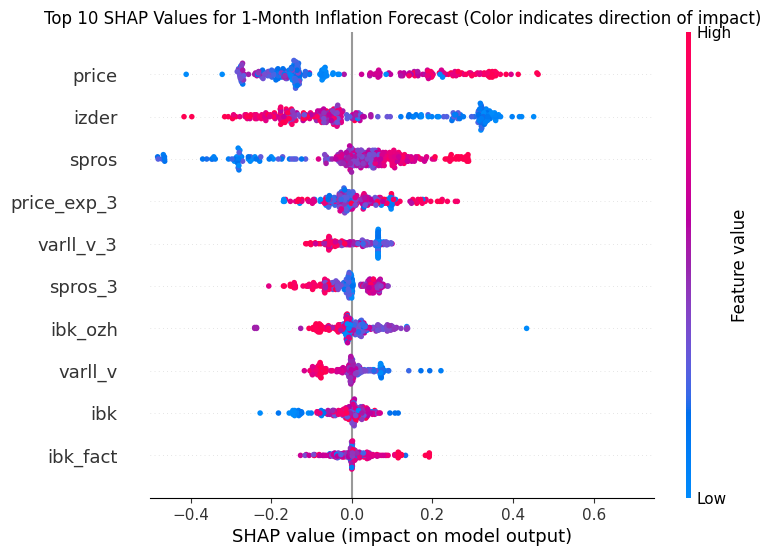

In [ ]:
#вариант 3
data_x = data.drop('t', axis=1)
random.seed(42)
os.makedirs('output_dir_2', exist_ok=True)

# 2. Обучение модели XGBoost для каждого горизонта прогнозирования
target = 't'

# Разделяем данные на признаки (features) и целевую переменную
data_y = data[target]

# Создаем и обучаем модель XGBoost
model = xgboost.XGBRegressor(random_state=42, objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=3)
model.fit(data_x, data_y)

# 3. Вычисление SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_x)

#shap.summary_plot(shap_values, data_x, max_display=10)

# 4. Определение наиболее значимых предикторов (топ-N)
shap_importance = pd.DataFrame(index=data_x.columns, data=np.abs(shap_values).mean(axis=0), columns=['mean(|SHAP|)'])
shap_importance['sign'] = np.sign(shap_values.mean(axis=0))  # Определяем знак влияния
top_n = 10  # Количество наиболее значимых предикторов
top_features = shap_importance.sort_values(by='mean(|SHAP|)', ascending=False).head(top_n).index

# 5. Фильтрация SHAP values и данных для топ-N предикторов
shap_values_top = shap_values[:, data_x.columns.isin(top_features)]
data_x_top = data_x[top_features]

# 6. Визуализация SHAP values для топ-N предикторов и сохранение в файл .jpg
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, data_x, plot_type="dot", max_display=10, show=False)
plt.xlim(-0.5, 0.75)
plt.title(f'Top {top_n} SHAP Values for {srok_pr}-Month Inflation Forecast (Color indicates direction of impact)')
plt.savefig(os.path.join('output_dir_2', f'shap_summary_{srok_pr}_months.jpg'), format='jpg', bbox_inches='tight')
plt.show()
plt.close()  # Закрываем график, чтобы освободить память

# 7. Визуализация значимости предикторов с учетом знака и сохранение в файл .jpg
shap_importance_top = shap_importance.loc[top_features]

plt.figure(figsize=(10, 6))
colors = np.where(shap_importance_top['sign'] == 1, 'green', 'red')  # Зеленый для положительного, красный для отрицательного влияния
plt.barh(shap_importance_top.index, shap_importance_top['mean(|SHAP|)'], color=colors)
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.title(f'Top {top_n} Feature Importance for {srok_pr}-Month Inflation Forecast (Color indicates direction of impact)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.savefig(os.path.join('output_dir_2', f'feature_importance_{srok_pr}_months.jpg'), format='jpg', bbox_inches='tight')
plt.close()  # Закрываем график, чтобы освободить память

# 8. Сохранение SHAP values в Excel файл
shap_values_df = pd.DataFrame(shap_values_top, columns=data_x_top.columns)
#shap_values_df = pd.DataFrame(np.abs(shap_values_top), columns=X_test_features_top.columns)
shap_values_df.to_excel(os.path.join('output_dir_2', f'shap_values_{srok_pr}_months.xlsx'), index=False)

#shap_values_df = pd.DataFrame(np.abs(shap_values_top), columns=X_test_features_top.columns)
shap_importance_top.to_excel(os.path.join('output_dir_2', f'shap_importance_top{srok_pr}_months.xlsx'))

In [ ]:
# вариант 4 с выгрузкой всех значений
data_x = data.drop('t', axis=1)
random.seed(42)
os.makedirs('output_dir_2', exist_ok=True)

# 2. Обучение модели XGBoost для каждого горизонта прогнозирования
target = 't'

# Разделяем данные на признаки (features) и целевую переменную
data_y = data[target]

# Создаем и обучаем модель XGBoost
model = xgboost.XGBRegressor(random_state=42, objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=3)
model.fit(data_x, data_y)

# 3. Вычисление SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_x)

# 4. Определение наиболее значимых предикторов (топ-N)
shap_importance = pd.DataFrame(index=data_x.columns, data=np.abs(shap_values).mean(axis=0), columns=['mean(|SHAP|)'])
shap_importance['sign'] = np.sign(shap_values.mean(axis=0))  # Определяем знак влияния
top_n = 10  # Количество наиболее значимых предикторов
top_features = shap_importance.sort_values(by='mean(|SHAP|)', ascending=False).head(top_n).index

# 5. Фильтрация SHAP values и данных для топ-N предикторов
shap_values_top = shap_values[:, data_x.columns.isin(top_features)]
data_x_top = data_x[top_features]

# 6. Визуализация SHAP values для топ-N предикторов и сохранение в файл .jpg
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, data_x, plot_type="dot", max_display=10, show=False)
plt.xlim(-0.5, 0.75)
plt.title(f'Top {top_n} SHAP Values for {srok_pr}-Month Inflation Forecast (Color indicates direction of impact)')
plt.savefig(os.path.join('output_dir_2', f'shap_summary_{srok_pr}_months.jpg'), format='jpg', bbox_inches='tight')
plt.close()  # Закрываем график, чтобы освободить память

# 7. Визуализация значимости предикторов с учетом знака и сохранение в файл .jpg
shap_importance_top = shap_importance.loc[top_features]

plt.figure(figsize=(10, 6))
colors = np.where(shap_importance_top['sign'] == 1, 'green', 'red')  # Зеленый для положительного, красный для отрицательного влияния
plt.barh(shap_importance_top.index, shap_importance_top['mean(|SHAP|)'], color=colors)
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.title(f'Top {top_n} Feature Importance for {srok_pr}-Month Inflation Forecast (Color indicates direction of impact)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.savefig(os.path.join('output_dir_2', f'feature_importance_{srok_pr}_months.jpg'), format='jpg', bbox_inches='tight')
plt.close()  # Закрываем график, чтобы освободить память

# 8. Сохранение всех данных в Excel файлы
# Полные SHAP values для всех признаков
shap_values_full_df = pd.DataFrame(shap_values, columns=data_x.columns)
shap_values_full_df.to_excel(os.path.join('output_dir_2', f'shap_values_full_{srok_pr}_months.xlsx'), index=False)

# SHAP values только для топ-N признаков
shap_values_top_df = pd.DataFrame(shap_values_top, columns=data_x_top.columns)
shap_values_top_df.to_excel(os.path.join('output_dir_2', f'shap_values_top_{srok_pr}_months.xlsx'), index=False)

# Важность признаков (полная)
shap_importance_full = pd.DataFrame({
    'feature': data_x.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0),
    'mean_shap': shap_values.mean(axis=0),
    'direction': np.sign(shap_values.mean(axis=0))
})
shap_importance_full.to_excel(os.path.join('output_dir_2', f'shap_importance_full_{srok_pr}_months.xlsx'), index=False)

# Важность признаков (топ-N)
shap_importance_top.to_excel(os.path.join('output_dir_2', f'shap_importance_top_{srok_pr}_months.xlsx'))

# Дополнительно: базовые значения (expected values) из explainer
base_values_df = pd.DataFrame({
    'base_value': [explainer.expected_value],
    'description': ['Base (expected) value from SHAP explainer']
})
base_values_df.to_excel(os.path.join('output_dir_2', f'shap_base_values_{srok_pr}_months.xlsx'), index=False)

In [ ]:
# Получаем даты из индекса
dates = data.index

# Создаем DataFrame с данными для summary plot (только топ-10 признаков)
shap_summary_data_list = []

for feature in top_features:
    # Получаем индекс текущего признака в исходных данных
    feature_idx = data_x.columns.get_loc(feature)

    # Собираем данные для каждого признака
    temp_df = pd.DataFrame({
        'date': dates,
        'feature': feature,
        'shap_value': shap_values[:, feature_idx],
        'feature_value': data_x[feature].values,
        'mean_abs_shap': np.abs(shap_values[:, feature_idx]).mean()  # Для удобства анализа
    })
    shap_summary_data_list.append(temp_df)

# Объединяем все данные в один DataFrame
shap_summary_data = pd.concat(shap_summary_data_list, axis=0)

# Добавляем столбец с нормализованными значениями признаков
for feature in top_features:
    mask = shap_summary_data['feature'] == feature
    vals = shap_summary_data.loc[mask, 'feature_value']
    shap_summary_data.loc[mask, 'feature_value_normalized'] = (vals - vals.min()) / (vals.max() - vals.min())

# Сохраняем в Excel
shap_summary_data.to_excel(
    os.path.join('output_dir_2', f'shap_summary_plot_data_{srok_pr}_months.xlsx'),
    index=False,
    columns=['date', 'feature', 'shap_value', 'feature_value', 'feature_value_normalized', 'mean_abs_shap']
)

print(f"Данные summary plot (топ-10) с датами сохранены в shap_summary_plot_data_{srok_pr}_months.xlsx")

Данные summary plot (топ-10) с датами сохранены в shap_summary_plot_data_1_months.xlsx


In [ ]:
shap_summary_data

,date,feature,shap_value,feature_value,mean_abs_shap,feature_value_normalized
0,2003-02-01,price,0.267018,22.128903,0.191195,0.616203
1,2003-03-01,price,0.291368,20.078885,0.191195,0.552876
2,2003-04-01,price,0.142062,19.523793,0.191195,0.535728
3,2003-05-01,price,0.189196,19.946583,0.191195,0.548789
4,2003-06-01,price,0.154358,20.695586,0.191195,0.571926
...,...,...,...,...,...,...
258,2024-08-01,ibk_fact,-0.006138,-2.369691,0.034543,0.706613
259,2024-09-01,ibk_fact,0.005095,-0.764831,0.034543,0.737374
260,2024-10-01,ibk_fact,0.009633,-1.044013,0.034543,0.732023
261,2024-11-01,ibk_fact,0.004301,-3.093649,0.034543,0.692737


ЭКсперимент по временной структуре для shap

In [ ]:
def compute_tc_shap(model, X, window_size=12):
    """Вычисляет TC-SHAP для XGBoost."""
    explainer = shap.TreeExplainer(model)
    baseline = data_x.mean(axis=0).values.reshape(1, -1)  # Базовые значения для маскировки

    # SHAP для всего окна (phi(0, i))
    shap_full = explainer(data_x).values

    # TC-SHAP: для каждого шага t маскируем будущие значения
    tc_shap = np.zeros_like(shap_full)

    for t in range(window_size, len(data_x)):
        X_masked = data_x.copy()
        X_masked.iloc[t+1:] = baseline  # Маскируем всё после t

        # Вычисляем SHAP для подокна [t-window_size : t]
        shap_partial = explainer(X_masked.iloc[t-window_size:t]).values
        tc_shap[t-window_size:t] = shap_partial

    return tc_shap

# Применяем к тестовым данным
tc_shap_values = compute_tc_shap(model, data_x)

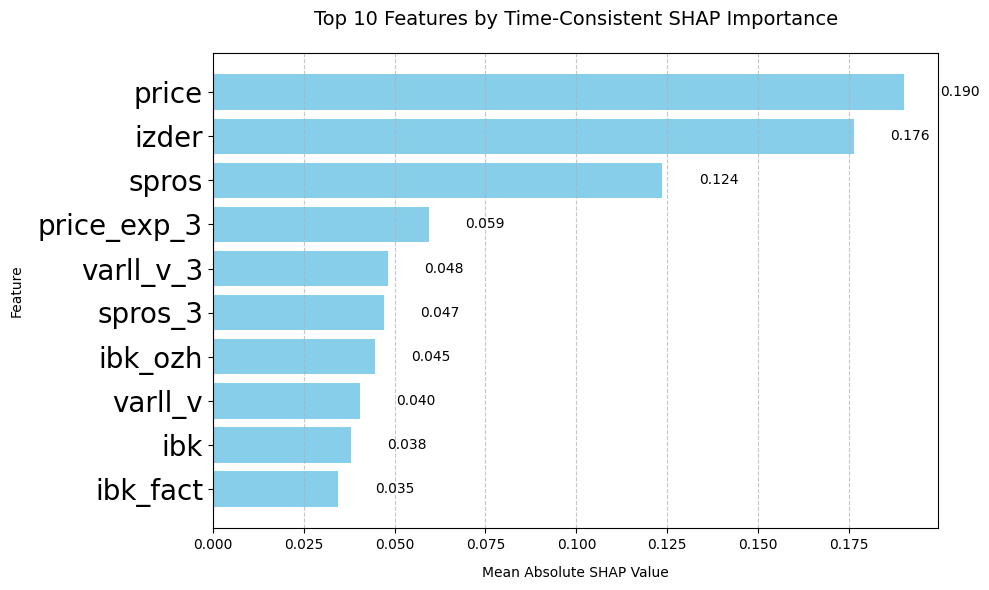


Top 10 Features by TC-SHAP Importance:
       feature  importance
0        price    0.190064
1        izder    0.176318
2        spros    0.123657
3  price_exp_3    0.059469
4    varll_v_3    0.048151
5      spros_3    0.047147
6      ibk_ozh    0.044690
7      varll_v    0.040368
8          ibk    0.037972
9     ibk_fact    0.034530


In [ ]:
# Усредняем важность по времени
feature_importance_tc = pd.DataFrame({
    "feature": data_x.columns,
    "importance": np.mean(np.abs(tc_shap_values), axis=0)
}).sort_values("importance", ascending=False).head(10)

# Создаем красивый горизонтальный барплот
plt.figure(figsize=(10, 6))
bars = plt.barh(
    feature_importance_tc["feature"][::-1],  # Переворачиваем для лучшего отображения
    feature_importance_tc["importance"][::-1],
    color='skyblue'
)

# Добавляем значения на график
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.01,  # Небольшой отступ от столбца
        bar.get_y() + bar.get_height()/2,
        f'{width:.3f}',
        va='center',
        ha='left'
    )

# Настройки оформления
plt.title("Top 10 Features by Time-Consistent SHAP Importance", pad=20, fontsize=14)
plt.xlabel("Mean Absolute SHAP Value", labelpad=10)
plt.ylabel("Feature", labelpad=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Дополнительно выводим таблицу с топ-10 признаков
print("\nTop 10 Features by TC-SHAP Importance:")
print(feature_importance_tc.reset_index(drop=True))